# Caverns with constraints

In [1]:
import os

import cartopy.crs as ccrs
import contextily as cx
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar

from h2ss import data as rd
from h2ss import functions as fns

In [2]:
# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

## Halite data

In [3]:
ds, extent = rd.kish_basin_data_depth_adjusted(
    dat_path=os.path.join("data", "kish-basin"),
    bathymetry_path=os.path.join("data", "bathymetry"),
)

In [4]:
xmin, ymin, xmax, ymax = extent.total_bounds

## Constraints

### Exploration wells

In [5]:
# 500 m buffer - suggested in draft OREDP II p. 108
wells, wells_b = fns.constraint_exploration_well(
    data_path=os.path.join(
        "data",
        "exploration-wells",
        "Exploration_Wells_Irish_Offshore.shapezip.zip",
    )
)

### Wind farms

In [6]:
# the shapes are used as is without a buffer - suggested for renewable energy
# test site areas in draft OREDP II p. 109
wind_farms = fns.constraint_wind_farm(
    data_path=os.path.join(
        "data", "wind-farms", "wind-farms-foreshore-process.zip"
    ),
    dat_extent=extent,
)

### Frequent shipping routes

In [7]:
# 1 NM (1,852 m) buffer - suggested in draft OREDP II p. 108
shipping, shipping_b = fns.constraint_shipping_routes(
    data_path=os.path.join(
        "data", "shipping", "shipping_frequently_used_routes.zip"
    ),
    dat_extent=extent,
)

### Shipwrecks

In [8]:
# Archaeological Exclusion Zones recommendation - 100 m buffer
shipwrecks, shipwrecks_b = fns.constraint_shipwrecks(
    data_path=os.path.join(
        "data", "shipwrecks", "IE_GSI_MI_Shipwrecks_IE_Waters_WGS84_LAT.zip"
    ),
    dat_extent=extent,
)

### Subsea cables

In [9]:
# 750 m buffer - suggested in draft OREDP II p. 109-111
cables, cables_b = fns.constraint_subsea_cables(
    data_path=os.path.join("data", "subsea-cables", "KIS-ORCA.gpkg")
)

### Distance from salt formation edge

In [10]:
edge_buffer = fns.constraint_halite_edge(dat_xr=ds)

## Zones of interest

In [11]:
# height = 85 m, 500 m <= depth <= 2,000 m, diameter = 80 m,
# separation = 320 m
zones, zds = fns.zones_of_interest(
    dat_xr=ds, constraints={"height": 85, "min_depth": 500, "max_depth": 2000}
)

## Generate caverns

### Exclude only shipping routes, wind farms, and cables

In [12]:
caverns, caverns_excl = fns.generate_caverns_with_constraints(
    zones_gdf=zones,
    zones_ds=zds,
    dat_extent=extent,
    exclusions={"shipping": shipping_b, "edge": edge_buffer},
)

------------------------------------------------------------
Without constraints, excluding salt formation edges...
Number of potential caverns: 4,084
------------------------------------------------------------
Exclude shipping...
Number of potential caverns: 1,776
Caverns excluded: 56.51%
------------------------------------------------------------
Exclude wind farms...
No data specified!
------------------------------------------------------------
Exclude cables...
No data specified!
------------------------------------------------------------
Exclude wells...
No data specified!
------------------------------------------------------------
Exclude shipwrecks...
No data specified!
------------------------------------------------------------


In [13]:
caverns, caverns_excl = fns.generate_caverns_with_constraints(
    zones_gdf=zones,
    zones_ds=zds,
    dat_extent=extent,
    exclusions={"cables": cables_b, "edge": edge_buffer},
)

------------------------------------------------------------
Without constraints, excluding salt formation edges...
Number of potential caverns: 4,084
------------------------------------------------------------
Exclude shipping...
No data specified!
------------------------------------------------------------
Exclude wind farms...
No data specified!
------------------------------------------------------------
Exclude cables...
Number of potential caverns: 3,889
Caverns excluded: 4.77%
------------------------------------------------------------
Exclude wells...
No data specified!
------------------------------------------------------------
Exclude shipwrecks...
No data specified!
------------------------------------------------------------


In [14]:
caverns, caverns_excl = fns.generate_caverns_with_constraints(
    zones_gdf=zones,
    zones_ds=zds,
    dat_extent=extent,
    exclusions={"wind_farms": wind_farms, "edge": edge_buffer},
)

------------------------------------------------------------
Without constraints, excluding salt formation edges...
Number of potential caverns: 4,084
------------------------------------------------------------
Exclude shipping...
No data specified!
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 3,713
Caverns excluded: 9.08%
------------------------------------------------------------
Exclude cables...
No data specified!
------------------------------------------------------------
Exclude wells...
No data specified!
------------------------------------------------------------
Exclude shipwrecks...
No data specified!
------------------------------------------------------------


### Exclude all

In [12]:
caverns, caverns_excl = fns.generate_caverns_with_constraints(
    zones_gdf=zones,
    zones_ds=zds,
    dat_extent=extent,
    exclusions={
        "wells": wells_b,
        "wind_farms": wind_farms,
        "shipwrecks": shipwrecks_b,
        "shipping": shipping_b,
        "cables": cables_b,
        "edge": edge_buffer,
    },
)

------------------------------------------------------------
Without constraints, excluding salt formation edges...
Number of potential caverns: 4,084
------------------------------------------------------------
Exclude shipping...
Number of potential caverns: 1,776
Caverns excluded: 56.51%
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 1,416
Caverns excluded: 65.33%
------------------------------------------------------------
Exclude cables...
Number of potential caverns: 1,348
Caverns excluded: 66.99%
------------------------------------------------------------
Exclude wells...
Number of potential caverns: 1,348
Caverns excluded: 66.99%
------------------------------------------------------------
Exclude shipwrecks...
Number of potential caverns: 1,348
Caverns excluded: 66.99%
------------------------------------------------------------


In [16]:
caverns.describe()[["Thickness", "TopDepthSeabed"]]

,Thickness,TopDepthSeabed
count,1348.000000,1348.000000
mean,276.521542,1094.339404
std,79.516373,380.577830
min,175.012400,420.214316
25%,214.203125,766.233205
50%,259.453000,1074.276101
75%,327.029325,1375.896933
max,713.672500,1919.031682


In [17]:
# caverns in excluded areas
caverns_excl.describe()[["Thickness", "TopDepthSeabed"]]

,Thickness,TopDepthSeabed
count,2736.000000,2736.000000
mean,252.413455,1010.519892
std,72.240179,325.334523
min,175.045900,421.507445
25%,202.505075,740.151377
50%,236.332700,1005.971496
75%,278.103475,1249.405863
max,992.179400,1915.809278


In [14]:
# label caverns by height and depth
caverns = fns.label_caverns(
    cavern_df=caverns,
    heights=[85, 155, 311],
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

## Crop data layers

In [15]:
# land boundary
land = rd.read_shapefile_from_zip(
    data_path=os.path.join(
        "data", "boundaries", "osi-provinces-ungeneralised-2019.zip"
    )
)

land = land.dissolve().to_crs(rd.CRS)

In [16]:
# create exclusion buffer
buffer = pd.concat([wells_b, shipwrecks_b, shipping_b, cables_b]).dissolve()

In [17]:
# crop land areas from constraints and the buffer
# biospheres = biospheres.overlay(land, how="difference")
shipping = shipping.overlay(land, how="difference")
cables = cables.overlay(land, how="difference")
buffer = buffer.overlay(land, how="difference")

In [18]:
# # merge salt edge buffer
# buffer_edge = pd.concat(buffer_edge.values()).dissolve()

## Maps

In [21]:
def plot_map(dat_xr):
    """Helper function to plot constraints and exclusions"""
    # initialise figure
    plt.figure(figsize=(12, 8))
    axis = plt.axes(projection=ccrs.epsg(rd.CRS))

    # halite boundary - use buffering to smooth the outline
    shape = rd.halite_shape(dat_xr=dat_xr).buffer(1000).buffer(-1000)

    # configure map limits
    plt.xlim(shape.bounds["minx"][0] - 10000, shape.bounds["maxx"][0] + 1500)
    plt.ylim(shape.bounds["miny"][0] - 1500, shape.bounds["maxy"][0] + 1500)

    # configure legend entries
    legend_handles = []

    shape.plot(ax=axis, zorder=1, linewidth=0, facecolor="white", alpha=0.35)
    shape.plot(
        ax=axis,
        edgecolor=sns.color_palette("flare", 4)[-2],
        color="none",
        linewidth=2,
        zorder=3,
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            linewidth=2,
            label="Kish Basin boundary",
            edgecolor=sns.color_palette("flare", 4)[-2],
        )
    )

    # add constraint layers
    for df, color, label in zip(
        [buffer.overlay(wind_farms, how="difference"), wind_farms],
        ["slategrey", sns.color_palette("GnBu", 10)[-1]],
        ["Exclusion buffer", "Wind farm"],
    ):
        df.plot(
            ax=axis, facecolor="none", hatch="//", edgecolor=color, zorder=1
        )
        legend_handles.append(
            mpatches.Patch(
                facecolor="none", hatch="//", edgecolor=color, label=label
            )
        )

    for df, color, linewidth, label in zip(
        [cables, shipping],
        [sns.color_palette("GnBu", 10)[-4], sns.color_palette("flare", 4)[0]],
        [2, 3],
        ["Subsea cable", "Shipping route"],
    ):
        df.plot(ax=axis, color=color, linewidth=linewidth, zorder=2)
        legend_handles.append(
            Line2D([0], [0], color=color, label=label, linewidth=linewidth)
        )

    for df, marker, label in zip(
        [wells, shipwrecks], ["x", "+"], ["Exploration well", "Shipwreck"]
    ):
        df.plot(ax=axis, color="black", marker=marker, zorder=4)
        legend_handles.append(
            Line2D(
                [0],
                [0],
                marker=marker,
                linewidth=0,
                markeredgecolor="black",
                label=label,
            )
        )

    # add basemap and map elements
    cx.add_basemap(axis, crs=rd.CRS, source=cx.providers.CartoDB.Voyager)
    axis.gridlines(
        draw_labels={"bottom": "x", "left": "y"},
        alpha=0.25,
        color="darkslategrey",
    )
    axis.add_artist(
        ScaleBar(1, box_alpha=0, location="lower right", color="darkslategrey")
    )
    plt.legend(
        loc="lower right", bbox_to_anchor=(1, 0.05), handles=legend_handles
    )
    plt.title(None)

    plt.tight_layout()
    plt.show()

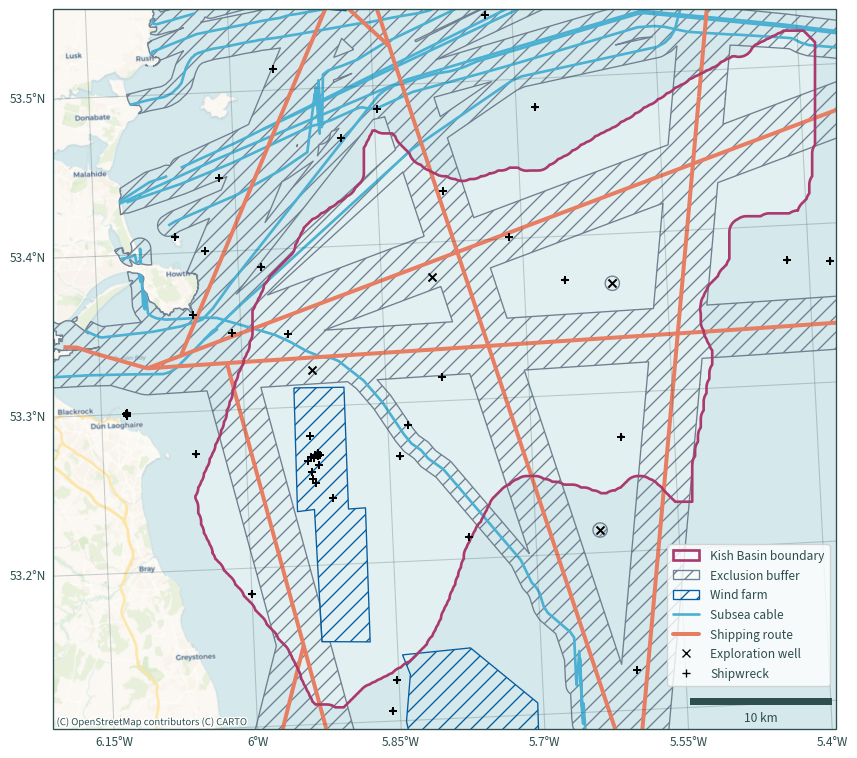

In [20]:
plot_map(ds)

In [24]:
def plot_map_alt(dat_xr, cavern_df, zones_gdf, fontsize=11.5):
    """Helper function to plot caverns within the zones of interest"""
    plt.figure(figsize=(20, 11.5))
    axis = plt.axes(projection=ccrs.epsg(rd.CRS))
    legend_handles = []

    # halite boundary - use buffering to smooth the outline
    shape = rd.halite_shape(dat_xr=dat_xr).buffer(1000).buffer(-1000)
    shape.plot(
        ax=axis,
        edgecolor="darkslategrey",
        color="none",
        linewidth=2,
        alpha=0.5,
        zorder=2,
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            linewidth=2,
            edgecolor="darkslategrey",
            label="Kish Basin boundary",
            alpha=0.5,
        )
    )

    zones_gdf.plot(
        ax=axis, zorder=1, linewidth=0, facecolor="white", alpha=0.45
    )
    zones_gdf.plot(
        ax=axis,
        zorder=2,
        edgecolor="slategrey",
        linestyle="dotted",
        linewidth=1.25,
        facecolor="none",
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            linestyle="dotted",
            edgecolor="slategrey",
            label="Area of interest",
            linewidth=1.25,
        )
    )

    pd.concat([buffer, wind_farms]).dissolve().clip(shape).plot(
        ax=axis,
        facecolor="none",
        linewidth=0.65,
        edgecolor="slategrey",
        zorder=2,
        alpha=0.5,
        hatch="//",
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            hatch="//",
            edgecolor="slategrey",
            label="Exclusion",
            alpha=0.65,
            linewidth=0.5,
        )
    )

    for df, markersize in zip(
        [
            cavern_df[cavern_df["depth"] == "500 - 1,000"],
            cavern_df[cavern_df["depth"] == "1,000 - 1,500"],
            cavern_df[cavern_df["depth"] == "1,500 - 2,000"],
        ],
        [20, 50, 20],
    ):
        gpd.GeoDataFrame(df, geometry=df.centroid).plot(
            ax=axis,
            column="Thickness",
            zorder=3,
            markersize=markersize,
            cmap=sns.color_palette("flare", as_cmap=True),
            linewidth=0,
            marker=".",
            scheme="UserDefined",
            classification_kwds={"bins": [155 + 90, 311 + 90]},
        )
    legend_handles.append(
        mpatches.Patch(label="Cavern height [m]", visible=False)
    )
    palette = [
        sns.color_palette("flare", 256)[0],
        sns.color_palette("flare", 256)[127],
        sns.color_palette("flare", 256)[-1],
    ]
    for color, label in zip(palette, ["85", "155", "311"]):
        legend_handles.append(mpatches.Patch(facecolor=color, label=label))
    legend_handles.append(
        mpatches.Patch(label="Cavern top depth [m]", visible=False)
    )
    for markersize, label in zip(
        [6, 3], ["1,000 - 1,500", "500 - 1,000 or \n1,500 - 2,000"]
    ):
        legend_handles.append(
            Line2D(
                [0],
                [0],
                marker=".",
                linewidth=0,
                label=label,
                color="darkslategrey",
                markersize=markersize,
            )
        )

    plt.xlim(shape.bounds["minx"][0] - 1000, shape.bounds["maxx"][0] + 1000)
    plt.ylim(shape.bounds["miny"][0] - 1000, shape.bounds["maxy"][0] + 1000)

    cx.add_basemap(
        axis, crs=rd.CRS, source=cx.providers.CartoDB.VoyagerNoLabels, zoom=12
    )
    axis.gridlines(
        draw_labels={"bottom": "x", "left": "y"},
        alpha=0.25,
        color="darkslategrey",
        xlabel_style={"fontsize": fontsize},
        ylabel_style={"fontsize": fontsize},
    )
    axis.add_artist(
        ScaleBar(
            1,
            box_alpha=0,
            location="lower right",
            color="darkslategrey",
            width_fraction=0.0075,
            font_properties={"size": fontsize},
        )
    )
    plt.legend(
        loc="lower right",
        bbox_to_anchor=(1, 0.05),
        handles=legend_handles,
        fontsize=fontsize,
    )

    plt.tight_layout()
    plt.show()

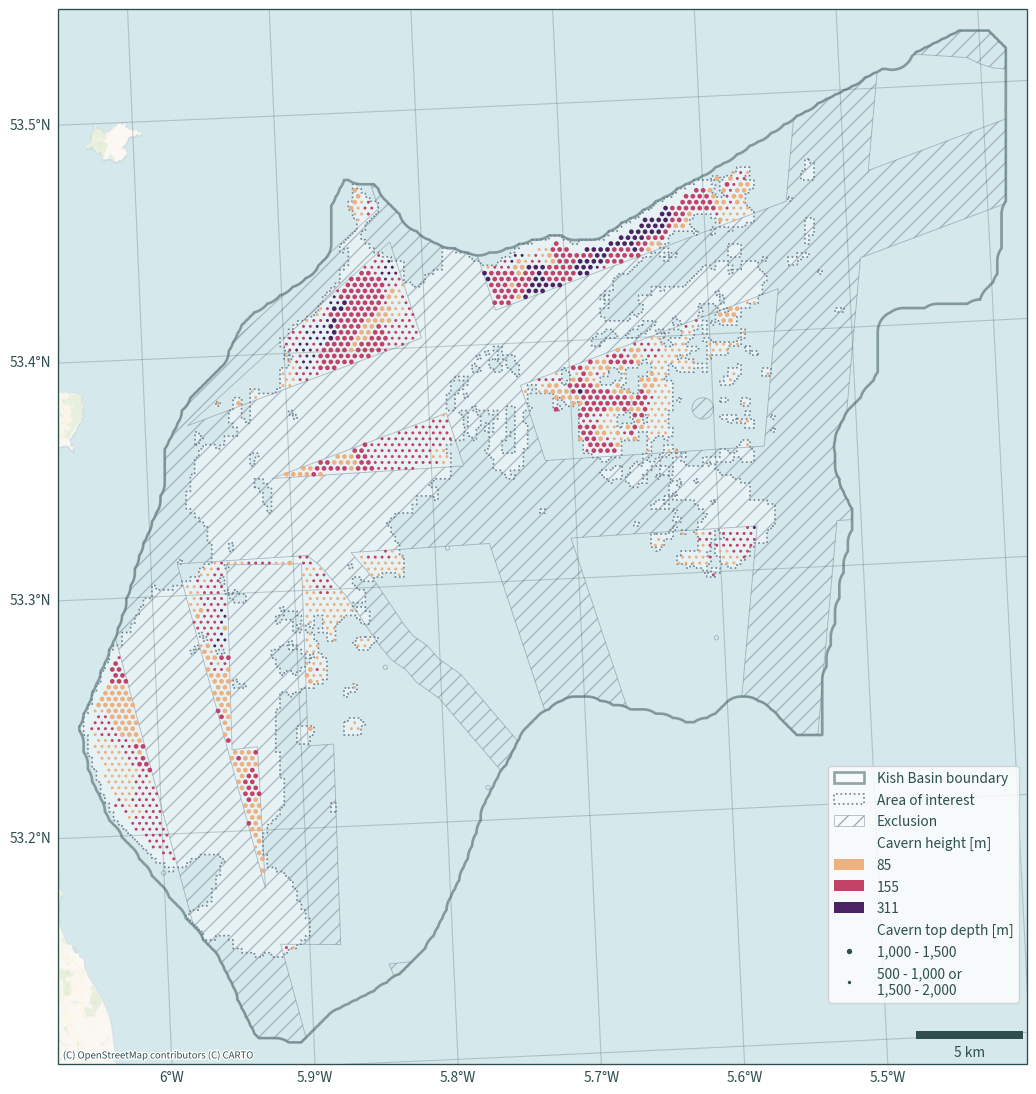

In [25]:
plot_map_alt(ds, caverns, zones)

## Stats

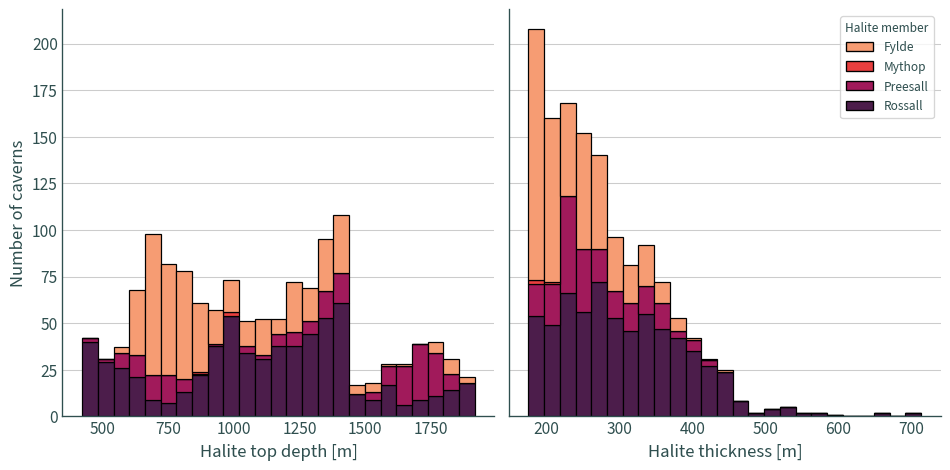

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.histplot(
    caverns.sort_values("halite"),
    x="TopDepthSeabed",
    palette="rocket_r",
    multiple="stack",
    hue="halite",
    alpha=1,
    bins=25,
    ax=axes[0],
    legend=False
)
sns.histplot(
    caverns.sort_values("halite").rename(columns={"halite": "Halite member"}),
    x="Thickness",
    hue="Halite member",
    palette="rocket_r",
    multiple="stack",
    alpha=1,
    bins=25,
    ax=axes[1],
)
axes[0].set_xlabel("Halite top depth [m]")
axes[1].set_xlabel("Halite thickness [m]")
axes[0].grid(which="major", axis="y")
axes[1].grid(which="major", axis="y")
axes[0].set_ylabel("Number of caverns")
sns.despine()
plt.tight_layout()
plt.show()

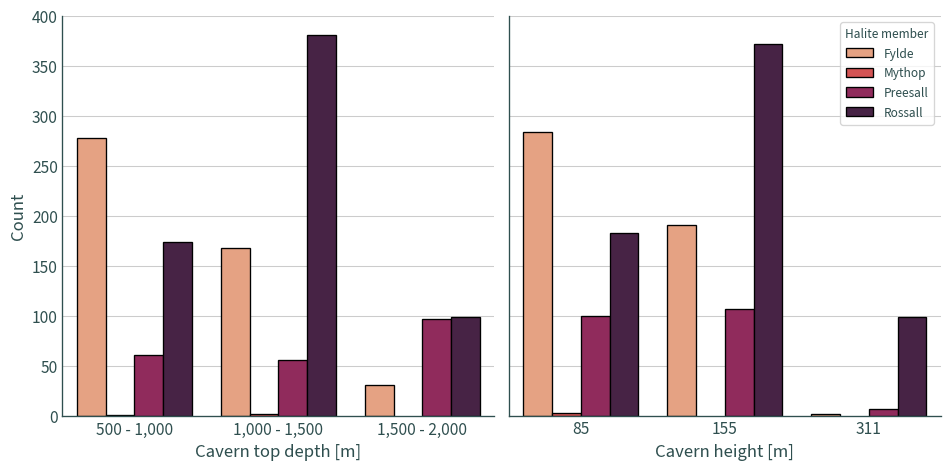

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.countplot(
    caverns.sort_values("halite"),
    ax=axes[0],
    x="depth",
    hue="halite",
    palette="rocket_r",
    legend=False,
    order=["500 - 1,000", "1,000 - 1,500", "1,500 - 2,000"],
    edgecolor="black",
)
axes[0].set_xlabel("Cavern top depth [m]")
sns.countplot(
    caverns.sort_values("halite"),
    ax=axes[1],
    x="height",
    hue="halite",
    palette="rocket_r",
    order=["85", "155", "311"],
    edgecolor="black",
)
axes[1].set_xlabel("Cavern height [m]")
axes[0].set_ylabel("Count")
axes[0].grid(which="major", axis="y")
axes[1].grid(which="major", axis="y")
plt.legend(title="Halite member")
sns.despine()
plt.tight_layout()
plt.show()

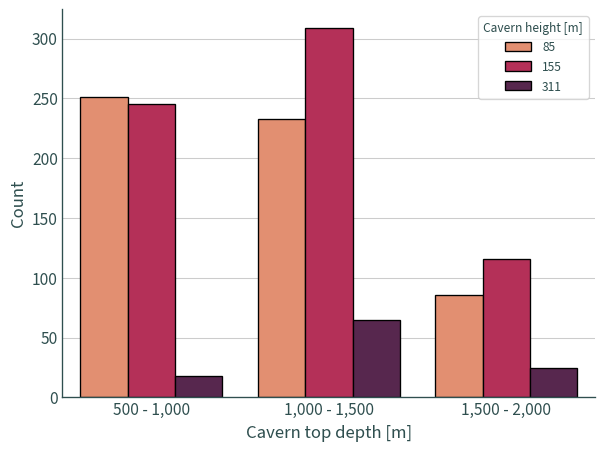

In [27]:
ax = sns.countplot(
    caverns.sort_values("Thickness"),
    x="depth",
    hue="height",
    palette="rocket_r",
    order=["500 - 1,000", "1,000 - 1,500", "1,500 - 2,000"],
    edgecolor="black",
)
ax.set_xlabel("Cavern top depth [m]")
ax.set_ylabel("Count")
ax.grid(which="major", axis="y")
sns.despine()
plt.legend(title="Cavern height [m]")
plt.tight_layout()
plt.show()

In [28]:
s = (
    caverns.sort_values("Thickness")
    .groupby("height", sort=False)
    .count()[["geometry"]]
)
s["%"] = s["geometry"] / len(caverns) * 100
s

,geometry,%
height,,
85,570,42.284866
155,670,49.703264
311,108,8.011869


In [29]:
s = (
    caverns.sort_values("TopDepthSeabed")
    .groupby("depth", sort=False)
    .count()[["geometry"]]
)
s["%"] = s["geometry"] / len(caverns) * 100
s

,geometry,%
depth,,
"500 - 1,000",514,38.130564
"1,000 - 1,500",607,45.029674
"1,500 - 2,000",227,16.839763


In [30]:
s = caverns.groupby(["height", "depth"], sort=False).count()[["geometry"]]
s["%"] = s["geometry"] / len(caverns) * 100
s

,,geometry,%
height,depth,,
155,"1,000 - 1,500",309,22.922849
85,"1,000 - 1,500",233,17.284866
311,"1,000 - 1,500",65,4.821958
155,"1,500 - 2,000",116,8.605341
85,"1,500 - 2,000",86,6.379822
311,"1,500 - 2,000",25,1.854599
85,"500 - 1,000",251,18.620178
155,"500 - 1,000",245,18.175074
311,"500 - 1,000",18,1.335312


In [26]:
s = caverns.groupby("halite", sort=False).count()[["geometry"]]
s["%"] = s["geometry"] / len(caverns) * 100
s

,geometry,%
halite,,
Rossall,654,48.516320
Fylde,477,35.385757
Preesall,214,15.875371
Mythop,3,0.222552


In [23]:
s = caverns.groupby(["halite", "height"], sort=False).count()[["geometry"]]
s["%"] = s["geometry"] / len(caverns) * 100
s

geometry          %
halite   height                     
Rossall  155          372  27.596439
         85           183  13.575668
         311           99   7.344214
Fylde    85           284  21.068249
         155          191  14.169139
         311            2   0.148368
Preesall 85           100   7.418398
         155          107   7.937685
         311            7   0.519288
Mythop   85             3   0.222552

In [25]:
s = caverns.groupby(["halite", "depth"], sort=False).count()[["geometry"]]
s["%"] = s["geometry"] / len(caverns) * 100
s

geometry          %
halite   depth                             
Rossall  1,000 - 1,500       381  28.264095
         1,500 - 2,000        99   7.344214
         500 - 1,000         174  12.908012
Fylde    1,000 - 1,500       168  12.462908
         1,500 - 2,000        31   2.299703
         500 - 1,000         278  20.623145
Preesall 1,000 - 1,500        56   4.154303
         1,500 - 2,000        97   7.195846
         500 - 1,000          61   4.525223
Mythop   1,000 - 1,500         2   0.148368
         500 - 1,000           1   0.074184

In [22]:
s = caverns.groupby(["halite", "height", "depth"], sort=False).count()[
    ["geometry"]
]
s["%"] = s["geometry"] / len(caverns) * 100
s

geometry          %
halite   height depth                             
Rossall  155    1,000 - 1,500       234  17.359050
         85     1,000 - 1,500        84   6.231454
         311    1,000 - 1,500        63   4.673591
         155    1,500 - 2,000        54   4.005935
         85     1,500 - 2,000        20   1.483680
         311    1,500 - 2,000        25   1.854599
         85     500 - 1,000          79   5.860534
         155    500 - 1,000          84   6.231454
         311    500 - 1,000          11   0.816024
Fylde    85     1,000 - 1,500       106   7.863501
         155    1,000 - 1,500        60   4.451039
         311    1,000 - 1,500         2   0.148368
         85     1,500 - 2,000        21   1.557864
         155    1,500 - 2,000        10   0.741840
         85     500 - 1,000         157  11.646884
         155    500 - 1,000         121   8.976261
Preesall 85     1,000 - 1,500        41   3.041543
         155    1,000 - 1,500        15   1.112760
                1,500 - 2,000        52   3.857567
         85     1,500 - 2,000        45   3.338279
         155    500 - 1,000          40   2.967359
         311    500 - 1,000           7   0.519288
         85     500 - 1,000          14   1.038576
Mythop   85     1,000 - 1,500         2   0.148368
                500 - 1,000           1   0.074184